# SF Salinity KOs, LASSO CV to predict methane v.10

- v.10 working functions, consistent, cleans v0.9 cruft
- v0.9 Finds / fixes inconsistencies among versions, comments out old code
- v0.8 uses / reorgs new Lasso functions
- v0.7 makes new functions for Lasso
- v0.6 cleans guild features, data still below
- v0.5 redoes import functions, v0.4 was last but data issues, last figs from v0.2 UMX..

- note this vers. also uses cdips2017 py version, others may be missing SKlearn components like Robust Scaler, scorers, etc.

### 0) Import modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import matplotlib
import scipy

import warnings
warnings.filterwarnings('ignore')

import sklearn as sk

%matplotlib inline
from matplotlib import gridspec
from matplotlib.backends.backend_pdf import PdfPages
sns.set_style("white")
sns.set_style("ticks")

In [2]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

In [3]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn import metrics

In [4]:
from sklearn.linear_model import RandomizedLasso

# 1) Import data: Environment, Genes, Ontology

- Env_chem, gene_ontol_colors, Gene_counts [used]

- also, Gene_abund [all genes, not restricted to ontology genes as in counts]

## a) Import & clean Environment data:

- Env_chem

- creates DELTA ONLY subset unless commented out

#### i) Import metadata (chemistry)

In [5]:
# Import and clean environment data
# Note for v0.5 input data is LINEAR (fix3, note fix 3.5 is missing some of the below vars)
Sal_meta = pd.read_csv('SF_sal_meta_FIX3.txt', sep='\t', index_col=0)
Sal_meta['Salinity'] =  Sal_meta['Salinity.x']                                 #Sal_meta.columns # Sal_meta.head(10) # Sal_meta.EWcoastGroup.unique()

#### ii) Make environment subsets
- for oligo / Delta sites only analysis, or comment out below

In [6]:
###  LOW Salinity sites                                       # Sal_meta.SALTgroup.unique()
FW = Sal_meta[Sal_meta['SALTgroup'].str.contains('FW')]         # Get subsets 
Oligo = Sal_meta[Sal_meta['SALTgroup'].str.contains('Oligo')]
# Meso = Sal_meta[Sal_meta['SALTgroup'].str.contains('Meso')]

# DELTA ONLY sites
Oligo_FW = (FW, Oligo)                                           # Make set list 
Oligo_FW_sites = pd.concat(Oligo_FW)                             # Concat SET
Oligo_FW_sites.sort_values(by = 'Index', axis=0, inplace=True)   # Sort on Site index        

### REF SITES ONLY 
Ref_sites_ONLY = Sal_meta[Sal_meta['EWcoastGroup'].str.contains('SF_Ref')]

In [7]:
#### Select OLIGO only sites at own risk !!
# can just comment this line out:
Sal_meta=Oligo_FW_sites

#### iii) Select Env. Chem variables
- ignores some features like soil metals
- sets NA to 0.1 to fill missing porewater data (below detection)

In [8]:
## CUT Down Env. Data
env_chem_List = ['Salinity', 'Bulk_dens', 'H2O_FPS', 'CO2_mg_m2_h',                       # with log DATA, delete 'logCH4' now is logged, except for LIN vars
       'CO2_soilC_mg_g_d', 'CH4_ug_m2_h', 'CH4_CO2', 'CH4_soilC_ug_g_d', 'pH',            # Drop cations, corr w. Sal: 'Ca_pw', 'Sr_pw','Mg_pw', 'Na_pw', 'K_pw', 'Al_pw', 'Si_pw', 'Br_pw', 'F_pw', 'logCH4']
       'Cl', 'SO4', 'Corg_LOI', 'C', 'N', 'P', 'NO3_N', 'NH4_N', 'Olsen_P',               # Drop soil metals for now, half NA: 'Fe', 'Mn', 'Cu', 'Zn']
       'CN', 'CP', 'NP', 'NP_ext', 'NO3_NH4', 'C_g_m2', 'N_g_m2', 'P_g_m2',               # Drop redundant cols for PW: 'Salinity.x.1', 'CO2_mg_m2_h.1','CH4_ug_m2_h.1'
       'DOC_mg_L','Cl_pw', 'SO4_pw', 'NO2_pw', 'NO3_pw','NH3_pw',                         # Much more DELETED here, see earlier versions... # Sal_meta.columns # Env_chem.head()  
       'PO4_pw', 'Fe_pw', 'Mn_pw', 'Co_pw', 'Cu_pw', 'Zn_pw'] 
              
# ABSTRACT Env_chem
Env_chem = Sal_meta[env_chem_List]  # Get columns
Env_chem.fillna(0.1, inplace = True)  # Fill NAs w 0, for porewater ND - careful with soil metals

## ReINDEX Env. chem, MUST BE by Sample
Sample= Sal_meta['Sample'] 
Env_chem = Env_chem.set_index(Sample,0) 
del Env_chem.index.name        

In [9]:
# Drop bad porewater data from above
drop_vars = ['NO2_pw', 'NO3_pw','NH3_pw', 'PO4_pw']              # inorg N samps ruined, PO4 mostly 0/NA due to IC method
Env_chem.drop(drop_vars, axis = 1, inplace=True)

In [10]:
# Drop more non-sense variables 

#### iv) log transform data
- includes log n+1 for vars with negative values (like CH4 flux!)

In [11]:
# Log10 transform data set
Env_chem_log = np.log10(Env_chem)
# Env_chem_log.head()

In [12]:
# Get log(n+1 data) for select vars
log_n1_cols = ['CH4_ug_m2_h', 'CH4_CO2', 'CH4_soilC_ug_g_d']
log_n1_data = np.log(Env_chem[log_n1_cols] + 1)
# log_n1_data.head()

In [13]:
# Replace log N + 1 data
Env_chem_log['CH4_ug_m2_h'] =  log_n1_data['CH4_ug_m2_h']
Env_chem_log['CH4_CO2'] =  log_n1_data['CH4_CO2']
Env_chem_log['CH4_soilC_ug_g_d'] =  log_n1_data['CH4_soilC_ug_g_d']

In [14]:
# Fill NA in porewater
#Env_chem.fillna(0.1, inplace = True)  # Fill NAs w 0, for porewater ND - careful with soil metals


In [15]:
#Env_chem_log.head()

#### i) add back some vars as linear
- might not be worth it, ignore later...

In [16]:
# Get linear data
#linear_vars = ['CO2_mg_m2_h', 'CH4_ug_m2_h', 'Salinity']
#linear_data = Env_chem[linear_vars]
#linear_data.columns = ['Salinity_lin', 'CH4_m2_lin', 'CO2_m2_lin']

# add linear to log df
#Env_chem_log = pd.concat([Env_chem_log, linear_data], axis =1)

# rename to Env_chem for downstream code
Env_chem = Env_chem_log

In [17]:
# drop first row of data (Sandmound_cattail is not a "real" sample)
#Env_chem.drop(["Sandmound_CattailA_D1"], axis=0, inplace = True)

In [18]:
#Env_chem_log.head()
Env_chem.head()

,Salinity,Bulk_dens,H2O_FPS,CO2_mg_m2_h,CO2_soilC_mg_g_d,CH4_ug_m2_h,CH4_CO2,CH4_soilC_ug_g_d,pH,Cl,...,N_g_m2,P_g_m2,DOC_mg_L,Cl_pw,SO4_pw,Fe_pw,Mn_pw,Co_pw,Cu_pw,Zn_pw
Sandmound_CattailA_D1,-0.233021,-0.668042,1.947719,0.433113,-1.904776,-0.294157,-0.009445,-0.001171,0.795185,1.098298,...,2.570631,1.490321,1.209783,2.310777,-0.142366,2.627704,2.761387,-0.721246,0.240549,-1.0
Sandmound_TuleA_D1,-0.226634,-0.576150,1.931627,0.170561,-2.213225,1.699839,0.263921,0.018316,0.789581,1.142702,...,2.628513,1.616975,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0
Sandmound_TuleB_D1,-0.219956,-0.605605,1.902172,0.620485,-1.740932,-0.332596,-0.006803,-0.001232,0.797268,1.149835,...,2.607116,1.611879,1.070776,2.337650,-0.057744,2.795477,3.070042,-0.408935,0.130334,-1.0
Sandmound_TuleC_D1,-0.246824,-0.619023,1.925604,0.246613,-2.131642,0.655385,0.051144,0.003868,0.796574,1.116608,...,2.599644,1.613973,1.250420,2.743198,1.238397,3.579373,3.481973,0.315970,0.678518,-1.0
Sandmound_ThreeSqA_D1,-0.179428,-0.647915,1.914517,0.596982,-1.756729,0.537960,0.017862,0.003151,0.802774,1.134177,...,2.569174,1.510448,1.008174,2.500640,1.023458,2.505299,2.094017,-0.619789,0.499687,-1.0


## b) Import gene (KO) abundance table
- Gene_abund.head()

In [19]:
### IMPORT CHANGED HERE TO MAKE KO A COLUMN, not index
# MG RAST updated KO counts (12/17)
Gene_abund = pd.read_csv('RAST_KO_ordered133_R2_F200_DESeq2_nrm.txt', sep='\t')#, index_col=0)      # RAST_KO_ordered133_R2_F200_DESeq2_nrm.txt

# Old FOAM data
#Gene_abund= pd.read_csv('FOAM_KO_ordered_F500_DESeq2_nrm.txt', sep='\t')#, index_col=0)                # FOAM

del Gene_abund.index.name   # Drop row index name before transpose
#Gene_abundT = Gene_abund.T  # TRANSPOSE, samples as rows for join with ENV#    #Gene_abundT.head() # Gene_abundT.head() # Gene_list = Gene_abundT.columns  # Get gene list (for later)  -- acting wonky, no methods could be use  # mgRAST_KO_de

In [20]:
#Gene_abundT.head()
# Gene_abund.head()

## c) Import gene (KO) ontology data, merge w abundance  

- gene_ontol_colors [merged ontology and colors]
- Gene_counts [only CNPS genes]

In [21]:
# Import CNPS, CH4, Ferment genes
gene_ontol = pd.read_csv('Ontology_KO_CNPSch4_Fm_whh0.txt', sep='\t', index_col=0)             # CNPSch4_Fm_KO

In [22]:
## ADD Abbrev. gene NAMES
Ont = gene_ontol         # Rename Ont shorter
gene_ontol['sm_name'] = (Ont['KO']+ " " + Ont['L3'] + " " + Ont['gene'].str[:4])
gene_ontol['mid_name'] = (Ont['KO']+ " " + Ont['L3'] + " ( " + Ont['gene'].str[:4] + " ) " + Ont['fxn'].str[:18])  # gene_ontol.head()

In [23]:
### Import Gene colors
gene_colors = pd.read_csv('Ontol_KO_L2_Color_KEY_whh0.txt', sep='\t', index_col=0)         # gene_colors = gene_colors.iloc[:,4:6]                                  # why not keep it all and drop later?        # get L3 colors and cats    # gene_colors

#### Merge colors, Ontol
gene_ontol_colors = pd.merge(gene_ontol, gene_colors, on = 'L2', how='inner')  # Here changed to L2   # gene_colors.head() #gene_ontol_colors

In [24]:
#gene_ontol_colors.head()

#### i) subset ontology

In [25]:
### Get gene cycle subsets
gene_ontol_colors.head()
gene_ontol_colors.L1.unique()

Carbon = gene_ontol_colors[gene_ontol_colors['L1'].str.contains('Carbon')]             # L1 = Carbon 
Nitrogen = gene_ontol_colors[gene_ontol_colors['L1'].str.contains('Nitrogen')]         # L1 = Nitrogen
Phosphorus = gene_ontol_colors[gene_ontol_colors['L1'].str.contains('Phosphorus')]     # L1 = Phosphorus
Sulfur = gene_ontol_colors[gene_ontol_colors['L1'].str.contains('Sulfur')]             # L1 = Sulfur
CH4_cycling = gene_ontol_colors[gene_ontol_colors['L1'].str.contains('CH4_cycling')]   # L1 = CH4 
Fermentation = gene_ontol_colors[gene_ontol_colors['L1'].str.contains('Fermentation')] # L1 = Fermentaiton

NPS_CH4_LIST = [Nitrogen, Phosphorus, Sulfur, CH4_cycling]
#CNPS_CH4_LIST = [Nitrogen, Phosphorus, Sulfur, CH4_cycling]
# NPS_CH4 = pd.concat([NPS_CH4_LIST], 0) 

NPS_CH4 = pd.concat([Nitrogen, Phosphorus, Sulfur, CH4_cycling], 0)
CNPS_CH4 = pd.concat([Carbon, Nitrogen, Phosphorus, Sulfur, CH4_cycling], 0) 
CNPS_CH4f = pd.concat([Carbon, Nitrogen, Phosphorus, Sulfur, CH4_cycling, Fermentation], 0) 
# CNPS_CO2 = pd.concat([Carbon, Nitrogen, Phosphorus, Sulfur, CH4_cycling], 0) 

In [26]:
# Choose subset - own risk
gene_ontol_colors = CNPS_CH4
#gene_ontol_colors

#### ii) Get only CNPS_CH4 gene abundances for lasso

In [27]:
 # Get only KO abundance for genes in CNPS ontology
CH4nps_KOs = pd.DataFrame(gene_ontol_colors['KO'])                           # Get only KOs from ontology
CH4nps_KOabund = pd.merge(CH4nps_KOs, Gene_abund, on='KO', how='inner')      # merge CNPS KO vector with KO abundance 
CH4nps_KOabund = CH4nps_KOabund.set_index('KO')                              # Set index as KO before transpose

CH4nps_KOabund_T = CH4nps_KOabund.T                                          # Transpose
CH4nps_KOabund_T['Sample'] = CH4nps_KOabund_T.index                          # Get sample col from 
#CH4nps_KOabund_T.head()

Gene_counts = CH4nps_KOabund_T

# 2) LASSO functions

### a) scoring functions

In [28]:
def rsquared(x, y):
    """ Return R^2 where x and y are array-like."""

    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    return r_value**2

In [29]:
# Define error measure for official scoring : RMSE
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring = "neg_mean_squared_error", cv = 10))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test, y_test, scoring = "neg_mean_squared_error", cv = 10))
    return(rmse)

#def rmse_cv(model):

### b) prepare data, test train split

Guild_lasso_data = split_scale_data(Guild_abund, 'CH4_ug_m2_h', test_frac = 0.3, random_s = 0)

 data output is dict containing e.g. : X_train = Guild_lasso_data["X_train"]

In [30]:
def split_scale_data(data, y_var, test_frac, random_s = 0):
    
    # Split X and y
    X = data.drop([y_var], axis = 1)
    y = data[y_var]
          
    # Test train split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_frac, random_state = random_s)
    print("X_train : " + str(X_train.shape) + " | X_test : " + str(X_test.shape)); print("y_train : " + str(y_train.shape) + " | y_test : " + str(y_test.shape))

    # Scale split X data
    robSc = RobustScaler()
    X_trainS = pd.DataFrame(robSc.fit_transform(X_train))
    X_trainS.columns = X.columns
    
    X_testS = pd.DataFrame(robSc.fit_transform(X_test))
    X_testS.columns = X.columns
    
    X_all = pd.DataFrame(robSc.fit_transform(X))
    X_all.columns = X.columns
    
    # Get dict for output
    data = {"X_train": X_trainS, 
        "X_test": X_testS, 
        "y_train":y_train, 
        "y_test":y_test,
        'y':y,
        'X_all':X_all}

    return(data)
    

In [31]:
# Example Input data 
# Guild_abund = pd.DataFrame(Guild_abund)

In [32]:
# USE FUNCTION
#Guild_lasso_data = split_scale_data(Guild_abund, 'CH4_ug_m2_h', test_frac = 0.3)

# Access data in output dict
#X_train = Guild_lasso_data["X_train"]

### c) LASSO estimator function
Guild_lasso = lassoCV(X_train, y_train)

where: data = Guild_lasso_data; X_train = data["X_train"]; y_train = data["y_train"]

In [33]:
def lassoCV(X,y):
    from sklearn.linear_model import LassoCV
    model = LassoCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 
                          0.3, 0.6, 1], 
                max_iter = 50000, cv = 10)
    model.fit(X,y)
    alpha = model.alpha_
    print("Best alpha 1:", alpha)
    
    model = LassoCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, 
                          alpha * .9, alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15,
                          alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4], 
                    max_iter = 50000,cv = 10)
    model.fit(X,y)
    alpha = model.alpha_
    print("Best alpha 2:", alpha)
    print("Lasso RMSE on Training set :", rmse_cv_train(model).mean().round(2))
    print("Lasso RMSE on Test set :", rmse_cv_test(model).mean().round(2))
    
    return model

In [34]:
# Get input data
# data = Guild_lasso_data

# X_train = data["X_train"]
# y_train = data["y_train"]

In [35]:
# Demonstrate function
# Guild_lasso = lassoCV(X_train, y_train)

### d) plot model fit regressions
plot_model_fit_regs(Guild_lasso_data, Guild_lasso, fig_dim = (6, 3))

In [36]:
def plot_model_fit_regs(data, model, fig_dim = (6, 3)):
    
### Extract data and linear fit scores ###
    
    # Get test train data
    X_train = data["X_train"]
    y_train = data["y_train"]
    X_test = data["X_test"]
    y_test = data["y_test"]
    
    # Get predicted values of y
    y_test_las = model.predict(X_test)
    y_train_las = model.predict(X_train)

    # Get R2 for train and test
    train_accuracy = rsquared(y_train, y_train_las).round(3)
    test_accuracy = rsquared(y_test, y_test_las).round(3)

    # Get scores as labels, print
    R2_test = "R2_test ={}".format(test_accuracy)
    R2_train = "R2_train ={}".format(train_accuracy)
    print(R2_test); print(R2_train)    
    
### Plot regressions for test and train ###
    
    # Format plot grid
    fig = plt.figure(figsize= fig_dim)          # Define plot
    gs = gridspec.GridSpec(1, 2)                # Declare grid dimension
    gs.update(left=0, right=1, wspace=0.45)     # Fine tune panel spacing

    ax1 = plt.subplot(gs[0, 0])                 # 1st axis
    ax2 = plt.subplot(gs[0, 1])                 # 2nd axis

    # Plot labels
    ax1.set(title=R2_train, ylabel='Predicted')  # ax1 title, y lab                        
    ax2.set(title= R2_test)

    # Regplot of train and test
    sns.regplot(x=y_train, y=y_train_las, ax=ax1)
    sns.regplot(x=y_test, y=y_test_las, ax=ax2)

    fig = gs.tight_layout(fig)
    #fig.show()   

In [37]:
# Demonstrate function:
# plot_model_fit_regs(Guild_lasso_data, Guild_lasso, fig_dim = (6, 3))

### e) extract model coefficients

get_model_coef(Guild_lasso, Guild_lasso_data)

In [38]:
def get_model_coef(model, data):
    
    # Extract scaled coefficients
    X_train = data["X_train"]                                     # Get training data
    coef = pd.Series(model.coef_, index = X_train.columns)        # Get coefs from model

    # Get top 20 most important features                          # TODO -- this should be fixed with n max, IF ELSE
    imp_coef = pd.concat([coef.sort_values().head(10),
                          coef.sort_values().tail(10)])

    imp_coef = pd.DataFrame(imp_coef)                             # Make coef data frame
    imp_coef.columns= ["coef"]                                    # Name first column coef 
    imp_coef['var'] = imp_coef.index                              # copy index to 'var'
    imp_coef = imp_coef.drop_duplicates()                         # TODO - only needed b/c no IF ELSE above 
    return(imp_coef)

In [39]:
# get_model_coef(Guild_lasso, Guild_lasso_data)

### f) extract / plot model coefficients

plot_model_coef_colors(Guild_lasso, Guild_lasso_data, Guild_colors, fig_dim = (2.5, 4))

- note colors input table requires X vars are labeled 'var'

##### TODO - needs print feature option 

#pp = PdfPages("test_Lasso_SOILS_all_sites.pdf")                     # Initialize the pdf file -- before FIG elements
#pp.savefig()                                                        # Save the figure PDF created at top, else add file name .pdf  or  
#pp.close() 

In [40]:
def plot_model_coef_colors(model, data, colors, fig_dim = (3, 4)):
    
    # Extract scaled coefficients
    X_train = data["X_train"]                                     # Get training data
    coef = pd.Series(model.coef_, index = X_train.columns)        # Get coefs from model

    # Get top 20 most important features                          # TODO -- this should be fixed with n max, IF ELSE
    imp_coef = pd.concat([coef.sort_values().head(10),
                          coef.sort_values().tail(10)])

    imp_coef = pd.DataFrame(imp_coef)                             # Make coef data frame
    imp_coef.columns= ["coef"]                                    # Name first column coef 
    imp_coef['var'] = imp_coef.index                              # copy index to 'var'
    imp_coef = imp_coef.drop_duplicates()                         # TODO - only needed b/c no IF ELSE above 
    
    # Merge color info
    coef_info = pd.merge(imp_coef, colors, how='left')            # Merge with colors, ontology (incl sm. name)
    coef_info['color'] = coef_info['color'].fillna('#708090')     # fill missing colors, here slate grey
    pal = coef_info['color']                                      # get color pallete
    
    # PLOT
    fig = plt.figure(figsize=fig_dim)           # Define plot
    sns.barplot(data=imp_coef, y='var', x='coef', palette= pal)#, palette=pal) #, orient='h')

In [41]:
# Use function
# plot_model_coef_colors(Guild_lasso, Guild_lasso_data, Guild_colors, fig_dim = (2.5, 4))

# 3) Lasso models of GENES 
- incl. genes + soils

In [42]:
# Get CH4 data
CH4 = 'CH4_ug_m2_h'                                                  # abstraction ahead of function
CH4_flux_df = pd.DataFrame(Env_chem[CH4])                                 # make standalone DF
CH4_flux_df['Sample'] = CH4_flux_df.index                                  # get sample name from index
CH4_flux_df.shape            

(74, 2)

In [43]:
#CH4_flux_df.head()

In [44]:
# Merge with Gene data
CH4_genes = pd.merge(CH4_flux_df, Gene_counts, on='Sample')    # Merge Env var with KO abundance by Samp.
CH4_genes = CH4_genes.set_index('Sample')
CH4_genes.drop(['Sample'], axis = 1, inplace = True)
#CH4_genes.drop(['Sandmound_CattailA_D1'], inplace = True)

In [45]:
# Get test train split data
Genes_lasso_data = split_scale_data(CH4_genes, 'CH4_ug_m2_h', test_frac = 0.3, random_s = 5)

X_train : (42, 256) | X_test : (18, 256)
y_train : (42,) | y_test : (18,)


In [46]:
# Note, pipeline overfits compared to manual, huh?
# Alphas are quite different too...

# Genes_lasso_data["y_train"]
# Genes_lasso_data["X_train"]

Best alpha 1: 0.3
Best alpha 2: 0.21
Lasso RMSE on Training set : 1.77
Lasso RMSE on Test set : 1.57
R2_test =0.693
R2_train =0.842


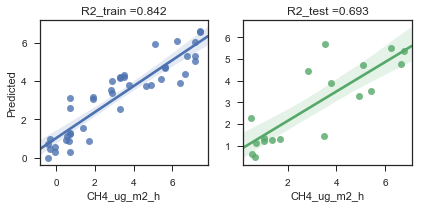

In [47]:
# Get LassoCV model
X_train = Genes_lasso_data["X_train"]
y_train = Genes_lasso_data["y_train"]
X_test = Genes_lasso_data["X_test"]
y_test = Genes_lasso_data["y_test"]

Gene_lasso = lassoCV(X_train, y_train)

# plot regression fits (model predicted)
plot_model_fit_regs(Genes_lasso_data, Gene_lasso)

In [48]:
# Get coefficients from Genes only model
Genes_coef = get_model_coef(Gene_lasso, Genes_lasso_data)

In [49]:
# Get gene colors and merge with coeff
gene_ontol_colors['var'] = gene_ontol_colors['KO']

coef_info = pd.merge(Genes_coef, gene_ontol_colors)    # Merge with colors, ontology (incl sm. name)
pal = coef_info['color']                             # get colors

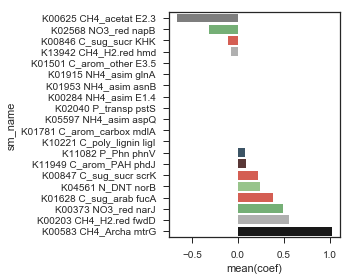

In [50]:
#pp = PdfPages("test_Lasso_Genes_no_TT.pdf")                     # Initialize the pdf file
fig = plt.figure(figsize=(5, 4))           # Define plot
sns.barplot(data=coef_info, y='sm_name', x='coef', palette=pal) #, orient='h')
fig.tight_layout()                    # Make tight layout
#pp.savefig()                            # Save the figure PDF created at top, else add file name .pdf  or  

### i) curr_function for colors not yet working, some issues around merging

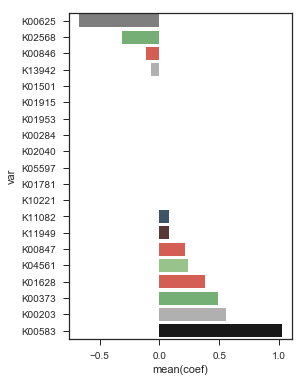

In [51]:
# Get gene colors 
gene_info = ["KO","color", "mid_name", "sm_name"]
Gene_colors = gene_ontol_colors[gene_info]
Gene_colors.columns = ["var","color", "mid_name", "sm_name"]
# Gene_colors

# gene_ontol_colors

# Plot scaled model coefficients
plot_model_coef_colors(Gene_lasso, Genes_lasso_data, Gene_colors, fig_dim = (4, 6))

# 4) LASSO model for soils only

### a) polish data

In [52]:
# drop some soil vars that conflict with CH4 out
## Better: Def var, drop var, append var.
Env_chem = Env_chem.drop(['CH4_CO2', "CH4_soilC_ug_g_d", "CO2_soilC_mg_g_d", 'Corg_LOI'], axis =1) # "CH4_m2_lin", 
Env_chem = Env_chem.drop(['C_g_m2', 'N_g_m2', 'P_g_m2'], axis =1)
Env_chem = Env_chem.drop(['Co_pw'], axis =1)

In [53]:
Env_chem.head()

,Salinity,Bulk_dens,H2O_FPS,CO2_mg_m2_h,CH4_ug_m2_h,pH,Cl,SO4,C,N,...,NP,NP_ext,NO3_NH4,DOC_mg_L,Cl_pw,SO4_pw,Fe_pw,Mn_pw,Cu_pw,Zn_pw
Sandmound_CattailA_D1,-0.233021,-0.668042,1.947719,0.433113,-0.294157,0.795185,1.098298,2.035430,1.224274,0.062582,...,1.424963,3.020759,-1.825397,1.209783,2.310777,-0.142366,2.627704,2.761387,0.240549,-1.0
Sandmound_TuleA_D1,-0.226634,-0.576150,1.931627,0.170561,1.699839,0.789581,1.142702,1.713491,1.173186,0.028571,...,1.356190,2.853644,-2.444825,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0
Sandmound_TuleB_D1,-0.219956,-0.605605,1.902172,0.620485,-0.332596,0.797268,1.149835,1.599883,1.180413,0.036629,...,1.339888,2.770441,-1.611116,1.070776,2.337650,-0.057744,2.795477,3.070042,0.130334,-1.0
Sandmound_TuleC_D1,-0.246824,-0.619023,1.925604,0.246613,0.655385,0.796574,1.116608,1.598791,1.216166,0.042576,...,1.330323,2.771369,-1.853872,1.250420,2.743198,1.238397,3.579373,3.481973,0.678518,-1.0
Sandmound_ThreeSqA_D1,-0.179428,-0.647915,1.914517,0.596982,0.537960,0.802774,1.134177,1.879096,1.230704,0.040998,...,1.403379,3.234183,-2.089670,1.008174,2.500640,1.023458,2.505299,2.094017,0.499687,-1.0


### b) CH4 ~ Soils LASSO model

In [54]:
# split data, test / train
Soil_lasso_data = split_scale_data(Env_chem, 'CH4_ug_m2_h', test_frac = 0.3, random_s = 5)

X_train : (51, 25) | X_test : (23, 25)
y_train : (51,) | y_test : (23,)


Best alpha 1: 0.1
Best alpha 2: 0.1
Lasso RMSE on Training set : 1.55
Lasso RMSE on Test set : 1.48
R2_test =0.795
R2_train =0.859


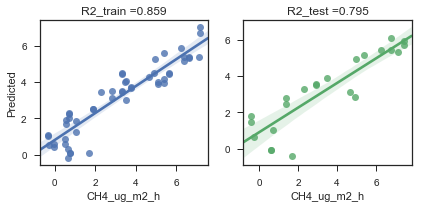

In [55]:
# Get LassoCV model
X_train = Soil_lasso_data["X_train"]
y_train = Soil_lasso_data["y_train"]

Soil_lasso = lassoCV(X_train, y_train)

# plot regression fits (model predicted)
plot_model_fit_regs(Soil_lasso_data, Soil_lasso)
# plot_model_coef_colors(Soil_lasso, Soil_lasso_data, Soil_colors, fig_dim = (4, 6))

In [56]:
# Need color matrix for parameter plots, var, color
Soil_colors = pd.DataFrame(X_train.columns)
Soil_colors['color'] = '#708090'
Soil_colors.columns = ['var', 'color']

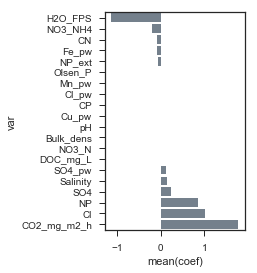

In [142]:
# Plot scaled model coefficients
plot_model_coef_colors(Soil_lasso, Soil_lasso_data, Soil_colors, fig_dim = (2.5, 4))

In [143]:
fig.savefig('saving-a-seaborn-plot-as-pdf-file.pdf')

# 5) LASSO Combined genes and soil

### a) input data, needs cleanup

In [58]:
# ATTEMPT TO CLEAN, BUT FAILING / moving on
# Combine data from:  Gene_counts  &  Env_chem

Env_chem2 = Env_chem
Env_chem2['Sample'] = Env_chem.index

Soil_Genes = pd.merge(Env_chem2, Gene_counts, on = 'Sample')
Soil_Genes.drop(['Sample'], axis = 1, inplace = True)
# Soil_Genes.head()
# Soil_Genes.columns

# Gene_counts.shape, Env_chem.shape, Soil_genes.shape

## LASSO method

X_train : (42, 281) | X_test : (18, 281)
y_train : (42,) | y_test : (18,)
Best alpha 1: 0.1
Best alpha 2: 0.09
Lasso RMSE on Training set : 1.45
Lasso RMSE on Test set : 1.48
R2_test =0.743
R2_train =0.948


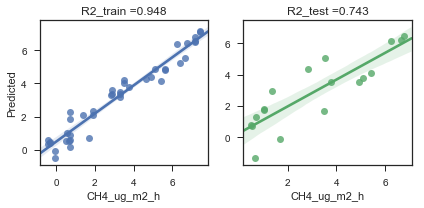

In [59]:
# split data, test / train
Soil_gene_data = split_scale_data(Soil_Genes, 'CH4_ug_m2_h', test_frac = 0.3, random_s = 5)

# Get LassoCV model
X_train = Soil_gene_data["X_train"]
y_train = Soil_gene_data["y_train"]

Soil_Gene_lasso = lassoCV(X_train, y_train)

# plot regression fits (model predicted)
plot_model_fit_regs(Soil_gene_data, Soil_Gene_lasso)
# plot_model_coef_colors(Soil_lasso, Soil_lasso_data, Soil_colors, fig_dim = (4, 6))



In [60]:
# Get coefficients from Genes Soils model
Soil_genes_coef = get_model_coef(Soil_Gene_lasso, Soil_gene_data)
# Soil_genes_coef

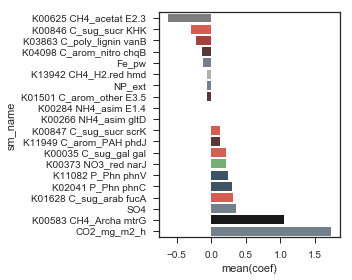

In [61]:
# Get gene colors and merge with coeff
gene_ontol_colors['var'] = gene_ontol_colors['KO']

coef_info = pd.merge(Soil_genes_coef, gene_ontol_colors, how = 'left')    # Merge with colors, ontology (incl sm. name)
coef_info['color'] = coef_info['color'].fillna('#708090')   
coef_info['sm_name'] = coef_info['sm_name'].fillna(coef_info['var'])      # IMPORTANT -- note fill var into new label
pal = coef_info['color']                             

# pal
#pp = PdfPages("test_Lasso_Genes_no_TT.pdf")                     # Initialize the pdf file
fig = plt.figure(figsize=(5, 4))           # Define plot
sns.barplot(data=coef_info, y='sm_name', x='coef', palette=pal) #, orient='h')
fig.tight_layout()                    # Make tight layout
#pp.savefig()                            # Save the figure PDF created at top, else add file name .pdf  or  

In [62]:
# Soil_gene_data

In [63]:
# gene_ontol_colors

# 6) LASSO on 16S guilds

### a) Import guild counts, get colors

In [64]:
Guild_counts = pd.read_csv('OTU_Guild_abundT_counts.txt', sep='\t')#, index_col=0)      # RAST_KO_ordered133_R2_F200_DESeq2_nrm.txt

In [65]:
# Log2 n+1 transform data
Guild_counts2 = Guild_counts.replace(0,2)                     # For log n+1, replace 0 with 2
Guild_countsLog2 = np.log2(Guild_counts2)                     # Get log2 data 
Guild_countsLog2 = Guild_countsLog2.replace(1,0)                  # Make 0 again 0

# Guild_countsLog2.head()

In [66]:
# To Filter only delta samples, or other
Guild_countsLog2["Sample"] = Guild_countsLog2.index           # Get sample column from index
# Guild_countsLog2

Guild_abund = pd.merge(CH4_flux_df, Guild_countsLog2, on='Sample')    # Merge Env var with KO abundance by Samp.
Guild_abund = Guild_abund.set_index('Sample')
#env_var_df# 

#Guild_abund.drop
Guild_abund= Guild_abund.iloc[:,0:16]                               # drops ratios
#Guild_abund = Guild_abund.drop(['MeOB','SOxB', 'FeRB', 'Anamx'], axis =1)
Guild_abund = Guild_abund.drop(['MeOB','SOxB', 'Anamx'], axis =1)
# Guild_abund.head()

In [67]:
# Get guild colors 
Guild_colors = pd.read_csv('Guild_color_palette.txt', sep ='\t') # sp error in name, may be used elsewhere though
Guild_colors['var'] = Guild_colors['Guild']
#Guild_colors.head()

### b) LASSO on Guilds

X_train : (51, 12) | X_test : (22, 12)
y_train : (51,) | y_test : (22,)
Best alpha 1: 0.01
Best alpha 2: 0.014
Lasso RMSE on Training set : 1.43
Lasso RMSE on Test set : 1.42
R2_test =0.598
R2_train =0.723


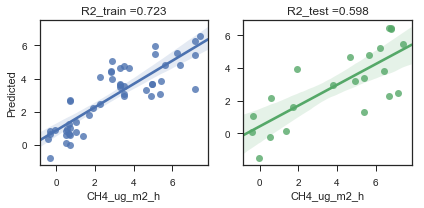

In [68]:
# split data, test / train
Guild_lasso_data = split_scale_data(Guild_abund, 'CH4_ug_m2_h', test_frac = 0.3, random_s = 5)

# Get LassoCV model
X_train = Guild_lasso_data["X_train"]
y_train = Guild_lasso_data["y_train"]

Guild_lasso = lassoCV(X_train, y_train)

# plot regression fits (model predicted)
plot_model_fit_regs(Guild_lasso_data, Guild_lasso)

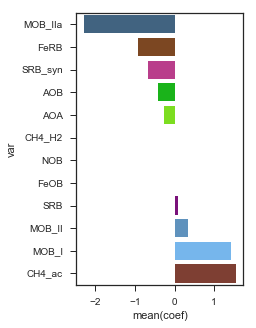

In [69]:
# Plot scaled model coefficients
plot_model_coef_colors(Guild_lasso, Guild_lasso_data, Guild_colors, fig_dim = (3, 5))

### c) combine guilds and chem data

In [70]:
# Combine datasets
Guilds_chem = pd.merge(Guild_abund, Env_chem)
Guilds_chem.set_index(['Sample'], drop = True, inplace = True) 
Guilds_chem.head()

# Fix color pal for guild chem
Guild_chem_colors = Guild_colors.append(Soil_colors)
Guild_chem_colors.drop(['G_index','Guild'], 1, inplace =True)
#Guild_soil_colors

X_train : (102, 37) | X_test : (44, 37)
y_train : (102,) | y_test : (44,)
Best alpha 1: 0.06
Best alpha 2: 0.054
Lasso RMSE on Training set : 0.97
Lasso RMSE on Test set : 1.46
R2_test =0.8
R2_train =0.886


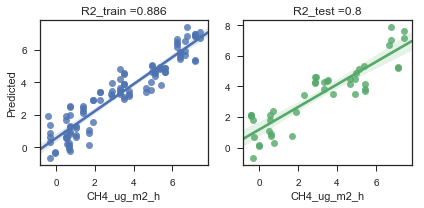

In [71]:
# split data, test / train
Guild_chem_data = split_scale_data(Guilds_chem, 'CH4_ug_m2_h', test_frac = 0.3, random_s = 0)

# Get LassoCV model
X_train = Guild_chem_data["X_train"]
y_train = Guild_chem_data["y_train"]

Guild_chem_lasso = lassoCV(X_train, y_train)

# plot regression fits (model predicted)
plot_model_fit_regs(Guild_chem_data, Guild_chem_lasso)

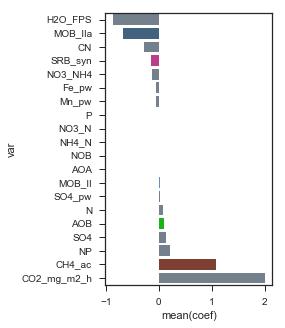

In [72]:
# Plot scaled model coefficients
plot_model_coef_colors(Guild_chem_lasso, Guild_chem_data, Guild_chem_colors, fig_dim = (3, 5))

### Combined data cruft

#### @@ combine guilds and chem

#### @@ combine guilds and genes

#### @@ guilds, chem, genes

In [73]:
#Guild_chem_genes.select_dtypes(exclude = ["object"]).columns

# 7) Lasso on Guild taxa 

### a) Import guild taxa

In [74]:
Guild_tax = pd.read_csv('CH4_guildG_log2abund_wkey.txt', sep='\t')#, index_col=0)      # RAST_KO_ordered133_R2_F200_DESeq2_nrm.txt
# Guild_tax.head()

In [75]:
# Get Guild_taxa_colors
#col_vars = ['Genus','Guild', 'color', 'G_index']
col_vars = ['Genus','color']
Guild_taxa_colors = Guild_tax[col_vars]
Guild_taxa_colors['var'] = Guild_taxa_colors['Genus']
#Guild_taxa_colors

In [76]:
# Get guild taxa data
drop_vars = ["Guild", "color", "G_index"]
Guild_taxa = Guild_tax.drop(drop_vars, 1)
Guild_taxa = Guild_taxa.set_index("Genus")
Guild_taxa = Guild_taxa.T
# Guild_taxa

In [77]:
# CH4_flux_df

In [78]:
# prepare dataset
Guild_taxa["Sample"] = Guild_taxa.index 
Guild_CH4_taxa = pd.merge(CH4_flux_df, Guild_taxa, on='Sample')
Guild_CH4_taxa = Guild_CH4_taxa.set_index('Sample')
Guild_CH4_taxa.head()

,CH4_ug_m2_h,Desulfobacter,Desulfosporosinus,Desulfovibrio,DesulfurellaceaeFA,GOUTA7,Halochromatium,Methanosaeta,MethanosarcinalesOR,Methylobacterium,...,Methyloversatilis,Nitrosopumilus,Nitrospira,NitrospiralesOR,SyntrophaceaeFA,Syntrophus,ThermoanaerobacteralesOR,Thiobacillus,Thiorhodovibrio,WSA2FA
Sample,,,,,,,,,,,,,,,,,,,,,
Sandmound_CattailA_D1,-0.294157,-0.686866,-0.788919,-0.437439,-0.385537,0.975211,0.295922,0.874994,-0.548065,0.160983,...,2.021758,0.065033,1.048475,1.322580,-0.655894,0.128565,-0.858456,0.167875,-0.167654,-0.516583
Sandmound_TuleB_D1,-0.332596,-0.686866,-1.460367,-1.191703,3.384473,2.121906,1.673740,-1.078138,-0.548065,-0.539888,...,-0.726099,2.326493,-1.433138,1.922468,-0.655894,-0.790602,1.831912,0.576184,-0.718953,-0.516583
Sandmound_TuleC_D1,0.655385,-0.686866,-1.460367,-1.191703,-0.385537,0.987128,-0.959491,0.288116,-0.548065,-0.539888,...,1.118909,0.257359,1.108310,1.677157,-0.655894,-0.790602,-0.858456,-0.376210,-0.006190,-0.516583
Sandmound_ThreeSqA_D1,0.537960,-0.686866,-0.338524,-1.191703,-0.385537,0.349612,-0.959491,0.291417,-0.548065,-0.539888,...,2.503547,-0.591641,1.467200,1.723266,-0.655894,-0.790602,-0.858456,-0.574594,-0.076094,-0.516583
Sandmound_ThreeSqB_D1,0.507858,-0.686866,-0.751874,-1.191703,-0.385537,0.108270,-0.959491,0.292155,-0.548065,-0.539888,...,2.012918,-0.591641,1.636997,1.578341,-0.655894,-0.790602,-0.858456,-0.513225,0.141002,0.344433


### b) guild Taxa model of CH4

X_train : (50, 22) | X_test : (22, 22)
y_train : (50,) | y_test : (22,)
Best alpha 1: 0.03
Best alpha 2: 0.0255
Lasso RMSE on Training set : 1.37
Lasso RMSE on Test set : 1.46
R2_test =0.529
R2_train =0.872


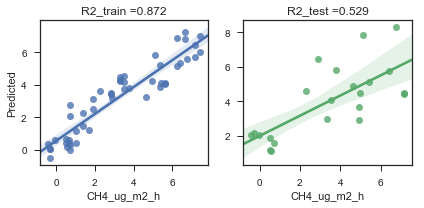

In [135]:
# split data, test / train
Guild_taxa_data = split_scale_data(Guild_CH4_taxa, 'CH4_ug_m2_h', test_frac = 0.3, random_s = 42)

# Get LassoCV model
X_train = Guild_taxa_data["X_train"]
y_train = Guild_taxa_data["y_train"]
X_test = Guild_taxa_data["X_test"]
y_test = Guild_taxa_data["y_test"]


Guild_taxa_lasso = lassoCV(X_train, y_train)

# plot regression fits (model predicted)
plot_model_fit_regs(Guild_taxa_data, Guild_taxa_lasso)
# plot_model_coef_colors(Soil_lasso, Soil_lasso_data, Soil_colors, fig_dim = (4, 6))


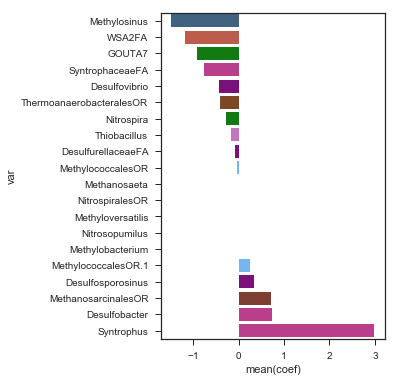

In [136]:
plot_model_coef_colors(Guild_taxa_lasso, Guild_taxa_data, Guild_taxa_colors, fig_dim = (4, 6))

### c) combine guild taxa and soil chem

In [81]:
# Combine datasets
Guilds_tax_chem = pd.merge(Guild_CH4_taxa, Env_chem)
Guilds_tax_chem.set_index(['Sample'], drop = True, inplace = True) 
#Guilds_chem.head()

# Fix color pal for guild chem
Guild_tax_chem_colors = Guild_taxa_colors.append(Soil_colors)
Guild_tax_chem_colors.drop(['Genus'], 1, inplace = True)

In [82]:
# Guild_chem_colors

X_train : (100, 47) | X_test : (44, 47)
y_train : (100,) | y_test : (44,)
Best alpha 1: 0.06
Best alpha 2: 0.054
Lasso RMSE on Training set : 1.08
Lasso RMSE on Test set : 1.01
R2_test =0.611
R2_train =0.915


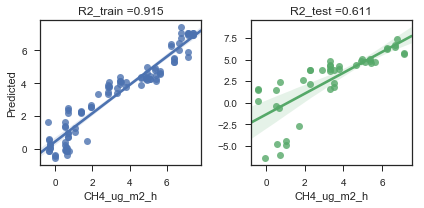

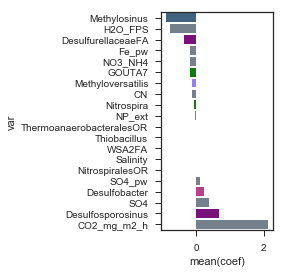

In [83]:
# split data, test / train
Guild_taxa_chem_data = split_scale_data(Guilds_tax_chem, 'CH4_ug_m2_h', test_frac = 0.3, random_s = 5)

# Get LassoCV model
X_train = Guild_taxa_chem_data["X_train"]
y_train = Guild_taxa_chem_data["y_train"]
X_test = Guild_taxa_chem_data["X_test"]
y_test = Guild_taxa_chem_data["y_test"]


Guild_taxa_chem_lasso = lassoCV(X_train, y_train)

# plot regression fits (model predicted)
plot_model_fit_regs(Guild_taxa_chem_data, Guild_taxa_chem_lasso)

# plot scaled coeffs
plot_model_coef_colors(Guild_taxa_chem_lasso, Guild_taxa_chem_data, Guild_tax_chem_colors, fig_dim = (2, 4))

### d) guilds, guild taxa

In [84]:
# Correct Taxa axis name from transpose
Guild_taxa = Guild_taxa.rename_axis("Sample", axis = "columns")

In [85]:
# Combine datasets
Guild_Gtax = Guild_abund.join(Guild_taxa)
Guild_Gtax.dropna(inplace = True)
Guild_Gtax.drop(['Sample'], axis = 1, inplace = True)

In [86]:
# Fix color pal for guild chem
Guild_Gtax_colors = Guild_colors.append(Guild_taxa_colors)
Guild_Gtax_colors.drop(['Genus', 'Guild', 'G_index'], 1, inplace = True)
# Guild_Gtax_colors

X_train : (50, 34) | X_test : (22, 34)
y_train : (50,) | y_test : (22,)
Best alpha 1: 0.03
Best alpha 2: 0.0255
Lasso RMSE on Training set : 1.77
Lasso RMSE on Test set : 1.44
R2_test =0.775
R2_train =0.85


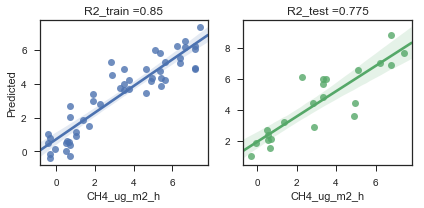

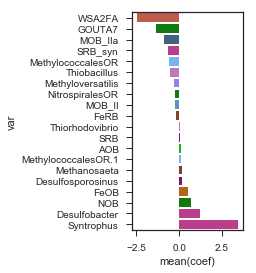

In [87]:
# split data, test / train
Guild_Gtaxa_data = split_scale_data(Guild_Gtax, 'CH4_ug_m2_h', test_frac = 0.3, random_s = 5)

# Get LassoCV model
X_train = Guild_Gtaxa_data["X_train"]
y_train = Guild_Gtaxa_data["y_train"]
X_test = Guild_Gtaxa_data["X_test"]
y_test = Guild_Gtaxa_data["y_test"]


Guild_Gtaxa_lasso = lassoCV(X_train, y_train)

# plot regression fits (model predicted)
plot_model_fit_regs(Guild_Gtaxa_data, Guild_Gtaxa_lasso)

# plot scaled coeffs
plot_model_coef_colors(Guild_Gtaxa_lasso, Guild_Gtaxa_data, Guild_Gtax_colors, fig_dim = (2, 4))

### e) Guilds, Guild tax, chem

In [88]:
# Combine datasets
Guild_Gtax_chem = Guilds_chem.join(Guild_taxa)
Guild_Gtax_chem.dropna(inplace = True)
Guild_Gtax_chem.drop(['Sample'], axis = 1, inplace = True)

In [89]:
# Get colors 
Guild_Gtax_chem_colors = Guild_tax_chem_colors.append(Guild_colors)
Guild_Gtax_chem_colors.drop(['G_index','Guild'], axis = 1, inplace = True)
#Guild_Gtax_chem_colors

X_train : (100, 59) | X_test : (43, 59)
y_train : (100,) | y_test : (43,)
Best alpha 1: 0.06
Best alpha 2: 0.069
Lasso RMSE on Training set : 1.06
Lasso RMSE on Test set : 1.05
R2_test =0.907
R2_train =0.885


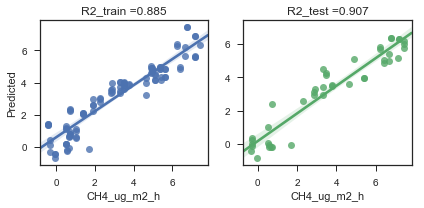

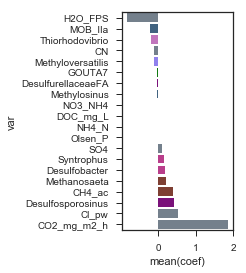

In [90]:
# split data, test / train
Guild_Gtaxa_chem_data = split_scale_data(Guild_Gtax_chem, 'CH4_ug_m2_h', test_frac = 0.3, random_s = 5)

# Get LassoCV model
X_train = Guild_Gtaxa_chem_data["X_train"]
y_train = Guild_Gtaxa_chem_data["y_train"]
X_test = Guild_Gtaxa_chem_data["X_test"]
y_test = Guild_Gtaxa_chem_data["y_test"]


Guild_Gtaxa_chem_lasso = lassoCV(X_train, y_train)

# plot regression fits (model predicted)
plot_model_fit_regs(Guild_Gtaxa_chem_data, Guild_Gtaxa_chem_lasso)

# plot scaled coeffs
plot_model_coef_colors(Guild_Gtaxa_chem_lasso, Guild_Gtaxa_chem_data, Guild_Gtax_chem_colors, fig_dim = (2, 4))

# 8) LASSO FOR SEM -- no test train
- permutations include guilds, chem, no CO2
- models with no test train labeled X, use data from above

## a) CH4 ~ Guilds

X_train : (51, 12) | X_test : (22, 12)
y_train : (51,) | y_test : (22,)
Best alpha 1: 0.06
Best alpha 2: 0.054
Lasso RMSE on Training set : 1.63
Lasso RMSE on Test set : 1.05
R2_test =0.738
R2_train =0.667


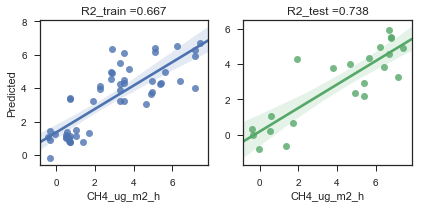

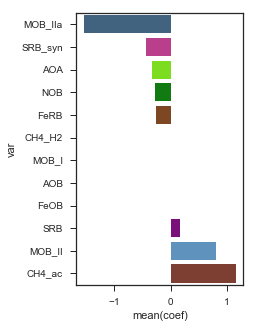

In [91]:
# split data, test / train
Guild_lasso_data = split_scale_data(Guild_abund, 'CH4_ug_m2_h', test_frac = 0.3, random_s = 5)

# Get LassoCV model
X_train = Guild_lasso_data["X_all"]
y_train = Guild_lasso_data["y"]

Guild_lassoX = lassoCV(X_train, y_train)

# plot regression fits (model predicted)
plot_model_fit_regs(Guild_lasso_data, Guild_lassoX)

# Plot scaled model coefficients
plot_model_coef_colors(Guild_lassoX, Guild_lasso_data, Guild_colors, fig_dim = (3, 5))

## b)  CH4 ~ Guilds and chem

### i) CH4 ~ all

Best alpha 1: 0.1
Best alpha 2: 0.14
Lasso RMSE on Training set : 1.33
Lasso RMSE on Test set : 0.99
R2_test =0.814
R2_train =0.865


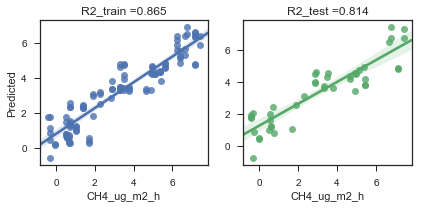

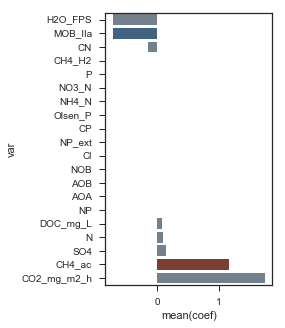

In [92]:
# split data, test / train
#Guild_chem_data = split_scale_data(Guilds_chem, 'CH4_ug_m2_h', test_frac = 0.3, random_s = 0)

# Get LassoCV model
X_train = Guild_chem_data["X_all"]
y_train = Guild_chem_data["y"]

Guild_chem_lassoX = lassoCV(X_train, y_train)

# plot regression fits (model predicted)
plot_model_fit_regs(Guild_chem_data, Guild_chem_lassoX)
# Plot scaled model coefficients
plot_model_coef_colors(Guild_chem_lassoX, Guild_chem_data, Guild_chem_colors, fig_dim = (3, 5))

### ii) CH4 ~ Guilds & Chem (no CO2)

In [93]:
Guilds_chemX = Guilds_chem.drop(['CO2_mg_m2_h'], axis = 1)
Guild_chem_dataX = split_scale_data(Guilds_chemX, 'CH4_ug_m2_h', test_frac = 0.3, random_s = 0)

X_train : (102, 36) | X_test : (44, 36)
y_train : (102,) | y_test : (44,)


Best alpha 1: 0.3
Best alpha 2: 0.21
Lasso RMSE on Training set : 1.71
Lasso RMSE on Test set : 1.09
R2_test =0.637
R2_train =0.705


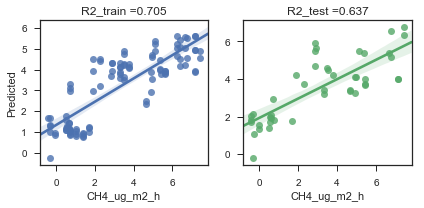

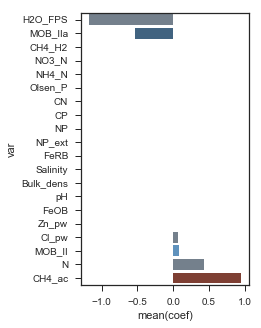

In [94]:
# split data, test / train


# Get LassoCV model
X_train = Guild_chem_dataX["X_all"]
y_train = Guild_chem_dataX["y"]

Guild_chem_lassoX = lassoCV(X_train, y_train)

# plot regression fits (model predicted)
plot_model_fit_regs(Guild_chem_dataX, Guild_chem_lassoX)
# Plot scaled model coefficients
plot_model_coef_colors(Guild_chem_lassoX, Guild_chem_dataX, Guild_chem_colors, fig_dim = (3, 5))

# 9) Taxa, taxa and chem

### a) CH4 vs. Guild taxa all

X_train : (50, 22) | X_test : (22, 22)
y_train : (50,) | y_test : (22,)
Best alpha 1: 0.03
Best alpha 2: 0.0225
Lasso RMSE on Training set : 1.39
Lasso RMSE on Test set : 1.04


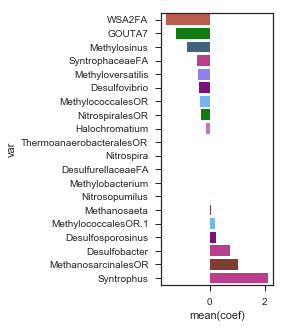

In [95]:
# split data, test / train
Guild_taxa_dataX = split_scale_data(Guild_CH4_taxa, 'CH4_ug_m2_h', test_frac = 0.3, random_s = 5)

# Get LassoCV model
X_train = Guild_taxa_dataX["X_all"]
y_train = Guild_taxa_dataX["y"]

Guild_taxa_lassoX = lassoCV(X_train, y_train)

# plot regression fits (model predicted)
#plot_model_fit_regs(Guild_taxa_dataX, Guild_taxa_lassoX)
# plot_model_coef_colors(Soil_lasso, Soil_lasso_data, Soil_colors, fig_dim = (4, 6))


plot_model_coef_colors(Guild_taxa_lassoX, Guild_taxa_dataX, Guild_taxa_colors, fig_dim = (2, 5))

### b) CH4 ~ Guilds + Guild taxa all

X_train : (50, 34) | X_test : (22, 34)
y_train : (50,) | y_test : (22,)
Best alpha 1: 0.03
Best alpha 2: 0.0225
Lasso RMSE on Training set : 1.38
Lasso RMSE on Test set : 1.04
R2_test =0.893
R2_train =0.797


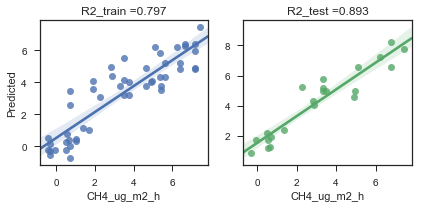

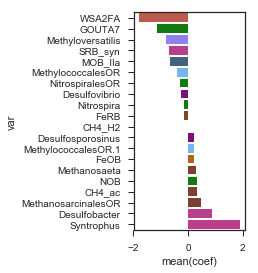

In [96]:
# split data, test / train
Guild_Gtaxa_dataX = split_scale_data(Guild_Gtax, 'CH4_ug_m2_h', test_frac = 0.3, random_s = 5)

# Get LassoCV model
X_train = Guild_Gtaxa_dataX["X_all"]
y_train = Guild_Gtaxa_dataX["y"]

Guild_Gtaxa_lassoX = lassoCV(X_train, y_train)

# plot regression fits (model predicted)
plot_model_fit_regs(Guild_Gtaxa_dataX, Guild_Gtaxa_lassoX)

# plot scaled coeffs
plot_model_coef_colors(Guild_Gtaxa_lassoX, Guild_Gtaxa_dataX, Guild_Gtax_colors, fig_dim = (2, 4))

### c) CH4 ~ Guild taxa + chem all

#### i) all chem

X_train : (100, 47) | X_test : (44, 47)
y_train : (100,) | y_test : (44,)
Best alpha 1: 0.06
Best alpha 2: 0.066
Lasso RMSE on Training set : 1.28
Lasso RMSE on Test set : 1.05
R2_test =0.717
R2_train =0.907


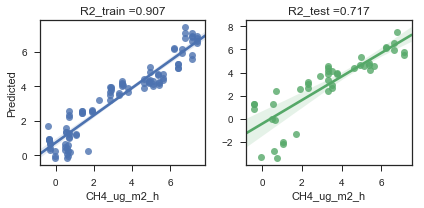

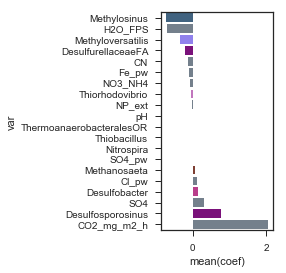

In [97]:
# split data, test / train
Guild_taxa_chem_data = split_scale_data(Guilds_tax_chem, 'CH4_ug_m2_h', test_frac = 0.3, random_s = 5)

# Get LassoCV model
X_train = Guild_taxa_chem_data["X_all"]
y_train = Guild_taxa_chem_data["y"]
#X_test = Guild_taxa_chem_data["X_test"]
#y_test = Guild_taxa_chem_data["y_test"]


Guild_taxa_chem_lassoX = lassoCV(X_train, y_train)

# plot regression fits (model predicted)
plot_model_fit_regs(Guild_taxa_chem_data, Guild_taxa_chem_lassoX)

# plot scaled coeffs
plot_model_coef_colors(Guild_taxa_chem_lassoX, Guild_taxa_chem_data, Guild_tax_chem_colors, fig_dim = (2, 4))

#### ii) no CO2, all chem

In [98]:
Guilds_tax_chemX = Guilds_tax_chem.drop(['CO2_mg_m2_h'], axis =1)

X_train : (100, 46) | X_test : (44, 46)
y_train : (100,) | y_test : (44,)
Best alpha 1: 0.1
Best alpha 2: 0.135
Lasso RMSE on Training set : 1.83
Lasso RMSE on Test set : 0.99
R2_test =0.653
R2_train =0.767


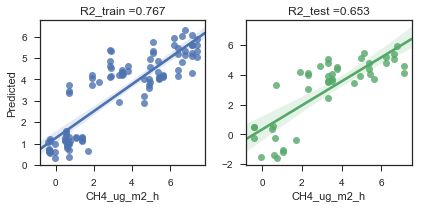

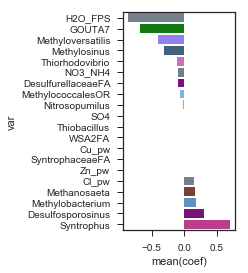

In [99]:
# split data, test / train
Guild_taxa_chem_dataX = split_scale_data(Guilds_tax_chemX, 'CH4_ug_m2_h', test_frac = 0.3, random_s = 5)

# Get LassoCV model
X_train = Guild_taxa_chem_dataX["X_all"]
y_train = Guild_taxa_chem_dataX["y"]
#X_test = Guild_taxa_chem_data["X_test"]
#y_test = Guild_taxa_chem_data["y_test"]


Guild_taxa_chem_lassoXX = lassoCV(X_train, y_train)

# plot regression fits (model predicted)
plot_model_fit_regs(Guild_taxa_chem_dataX, Guild_taxa_chem_lassoXX)

# plot scaled coeffs
plot_model_coef_colors(Guild_taxa_chem_lassoXX, Guild_taxa_chem_dataX, Guild_tax_chem_colors, fig_dim = (2, 4))

### d) CH4 ~ Guild taxa + Guilds + Chem

#### i) all chem

X_train : (100, 59) | X_test : (43, 59)
y_train : (100,) | y_test : (43,)
Best alpha 1: 0.1
Best alpha 2: 0.085
Lasso RMSE on Training set : 1.13
Lasso RMSE on Test set : 0.99
R2_test =0.917
R2_train =0.83


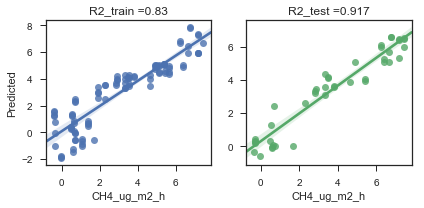

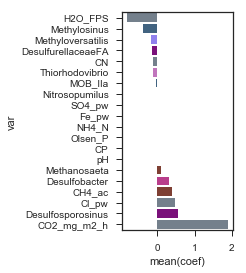

In [100]:
# split data, test / train
Guild_Gtaxa_chem_data = split_scale_data(Guild_Gtax_chem, 'CH4_ug_m2_h', test_frac = 0.3, random_s = 5)

# Get LassoCV model
X_train = Guild_Gtaxa_chem_data["X_all"]
y_train = Guild_Gtaxa_chem_data["y"]

Guild_Gtaxa_chem_lassoX = lassoCV(X_train, y_train)

# plot regression fits (model predicted)
plot_model_fit_regs(Guild_Gtaxa_chem_data, Guild_Gtaxa_chem_lassoX)

# plot scaled coeffs
plot_model_coef_colors(Guild_Gtaxa_chem_lassoX, Guild_Gtaxa_chem_data, Guild_Gtax_chem_colors, fig_dim = (2, 4))

#### ii) no CO2

In [101]:
Guild_Gtax_chemX = Guild_Gtax_chem.drop(['CO2_mg_m2_h'], axis=1)

X_train : (100, 58) | X_test : (43, 58)
y_train : (100,) | y_test : (43,)
Best alpha 1: 0.06
Best alpha 2: 0.054
Lasso RMSE on Training set : 1.51
Lasso RMSE on Test set : 1.05
R2_test =0.917
R2_train =0.83


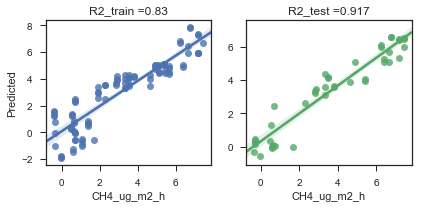

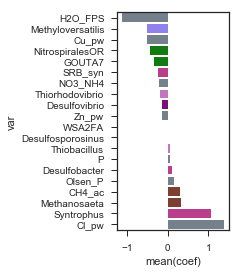

In [102]:
# split data, test / train
Guild_Gtaxa_chem_dataX = split_scale_data(Guild_Gtax_chemX, 'CH4_ug_m2_h', test_frac = 0.3, random_s = 5)

# Get LassoCV model
X_train = Guild_Gtaxa_chem_dataX["X_all"]
y_train = Guild_Gtaxa_chem_dataX["y"]

Guild_Gtaxa_chem_lassoXX = lassoCV(X_train, y_train)

# plot regression fits (model predicted)
plot_model_fit_regs(Guild_Gtaxa_chem_data, Guild_Gtaxa_chem_lassoX)

# plot scaled coeffs
plot_model_coef_colors(Guild_Gtaxa_chem_lassoXX, Guild_Gtaxa_chem_dataX, Guild_Gtax_chem_colors, fig_dim = (2, 4))

# 10) predict guilds ?

### a) drop CH4 from data

In [103]:
Guild_pred_data = Guilds_chem.drop(["CH4_ug_m2_h"], axis = 1)
# Guild_chem_colors

### b) predict CH4_ac

In [104]:
Guild_pred_data.columns

Index(['CH4_H2', 'CH4_ac', 'MOB_I', 'MOB_II', 'MOB_IIa', 'AOA', 'AOB', 'NOB',
       'SRB_syn', 'SRB', 'FeOB', 'FeRB', 'Salinity', 'Bulk_dens', 'H2O_FPS',
       'CO2_mg_m2_h', 'pH', 'Cl', 'SO4', 'C', 'N', 'P', 'NO3_N', 'NH4_N',
       'Olsen_P', 'CN', 'CP', 'NP', 'NP_ext', 'NO3_NH4', 'DOC_mg_L', 'Cl_pw',
       'SO4_pw', 'Fe_pw', 'Mn_pw', 'Cu_pw', 'Zn_pw'],
      dtype='object')

In [105]:
CH4_guild_data = Guild_pred_data.drop(['MOB_I', 'MOB_II', 'MOB_IIa', 'AOA', 'AOB', 'NOB'], axis = 1)

#### ii) guilds chem

X_train : (102, 29) | X_test : (44, 29)
y_train : (102,) | y_test : (44,)
Best alpha 1: 0.06
Best alpha 2: 0.048
Lasso RMSE on Training set : 1.68
Lasso RMSE on Test set : 1.05
R2_test =0.713
R2_train =0.706


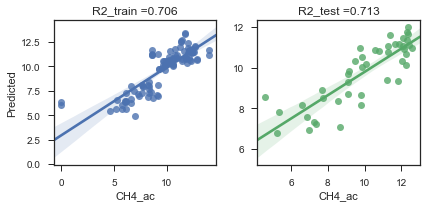

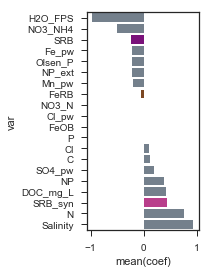

In [106]:
# split data, test / train
CH4_ac_guild_data = CH4_guild_data.drop('CH4_H2', axis=1)
CH4_ac_predata = split_scale_data(CH4_ac_guild_data, 'CH4_ac', test_frac = 0.3, random_s = 5)

# Get LassoCV model
X_train = CH4_ac_predata["X_all"]
y_train = CH4_ac_predata["y"]

CH4_ac_lassoX = lassoCV(X_train, y_train)

# plot regression fits (model predicted)
plot_model_fit_regs(CH4_ac_predata, CH4_ac_lassoX)

# plot scaled coeffs
plot_model_coef_colors(CH4_ac_lassoX, CH4_ac_predata, Guild_chem_colors, fig_dim = (2, 4))

### c) predict MOB_IIa

In [107]:
Guild_pred_data.columns


Index(['CH4_H2', 'CH4_ac', 'MOB_I', 'MOB_II', 'MOB_IIa', 'AOA', 'AOB', 'NOB',
       'SRB_syn', 'SRB', 'FeOB', 'FeRB', 'Salinity', 'Bulk_dens', 'H2O_FPS',
       'CO2_mg_m2_h', 'pH', 'Cl', 'SO4', 'C', 'N', 'P', 'NO3_N', 'NH4_N',
       'Olsen_P', 'CN', 'CP', 'NP', 'NP_ext', 'NO3_NH4', 'DOC_mg_L', 'Cl_pw',
       'SO4_pw', 'Fe_pw', 'Mn_pw', 'Cu_pw', 'Zn_pw'],
      dtype='object')

In [108]:
MOBIIa_guild_data = Guild_pred_data.drop(['MOB_I', 'MOB_II','SRB_syn', 'SRB', 'FeOB', 'FeRB', 'CH4_H2'], axis = 1)

X_train : (102, 29) | X_test : (44, 29)
y_train : (102,) | y_test : (44,)
Best alpha 1: 0.03
Best alpha 2: 0.0285
Lasso RMSE on Training set : 1.56
Lasso RMSE on Test set : 1.04
R2_test =0.757
R2_train =0.676


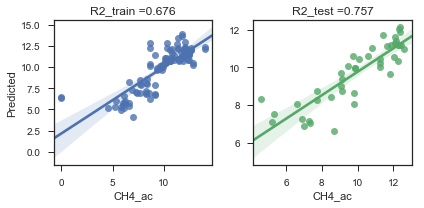

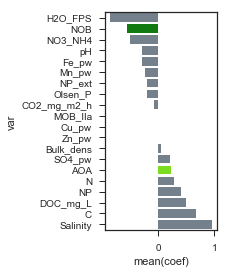

In [109]:
# split data, test / train

MOBIIa_predata = split_scale_data(MOBIIa_guild_data, 'CH4_ac', test_frac = 0.3, random_s = 5)

# Get LassoCV model
X_train = MOBIIa_predata["X_all"]
y_train = MOBIIa_predata["y"]

MOB_IIa_lassoX = lassoCV(X_train, y_train)

# plot regression fits (model predicted)
plot_model_fit_regs(MOBIIa_predata, MOB_IIa_lassoX)

# plot scaled coeffs
plot_model_coef_colors(MOB_IIa_lassoX, MOBIIa_predata, Guild_chem_colors, fig_dim = (2, 4))

# 11) Predict CO2 flux

### a) Chem only

In [110]:
# split data, test / train
Env_chem_CO2 = Env_chem.drop(['CH4_ug_m2_h', 'Sample'], axis = 1)
CO2_mod_data = split_scale_data(Env_chem_CO2, 'CO2_mg_m2_h', test_frac = 0.3, random_s = 5)

X_train : (51, 24) | X_test : (23, 24)
y_train : (51,) | y_test : (23,)


Best alpha 1: 0.01
Best alpha 2: 0.014
Lasso RMSE on Training set : 0.34
Lasso RMSE on Test set : 1.16
R2_test =0.485
R2_train =0.403


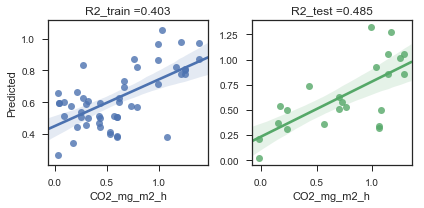

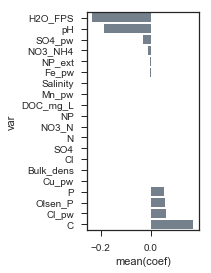

In [111]:
# Get LassoCV model
X_train = CO2_mod_data["X_all"]
y_train = CO2_mod_data["y"]

CO2_lassoX = lassoCV(X_train, y_train)

# plot regression fits (model predicted)
plot_model_fit_regs(CO2_mod_data, CO2_lassoX)

# plot scaled coeffs
plot_model_coef_colors(CO2_lassoX, CO2_mod_data, Soil_colors, fig_dim = (2, 4))

### b) chem and genes

#### i) modify gene counts by ontology categories as necessary

In [112]:
# Retrieve subsets of ontology, starting with all -- CAN MODIFY

CNPS_CH4f = pd.concat([Carbon, Nitrogen, Phosphorus, Sulfur, CH4_cycling, Fermentation], 0) 
Cf = pd.concat([Carbon, Fermentation], 0) 

#gene_ontol_colors = CNPS_CH4f
# gene_ontol_colors = CNPS_CH4
# gene_ontol_colors = Carbon
gene_ontol_colors = Cf

In [113]:
# gene_ontol_colors

#### ii) Gene abundance matrix 

In [114]:
# Get only KO abundance for genes in CNPS ontology
CH4nps_KOs = pd.DataFrame(gene_ontol_colors['KO'])                           # Get only KOs from ontology
CH4nps_KOabund = pd.merge(CH4nps_KOs, Gene_abund, on='KO', how='inner')      # merge CNPS KO vector with KO abundance 
CH4nps_KOabund = CH4nps_KOabund.set_index('KO')                              # Set index as KO before transpose

CH4nps_KOabund_T = CH4nps_KOabund.T                                          # Transpose
CH4nps_KOabund_T['Sample'] = CH4nps_KOabund_T.index                          # Get sample col from 
#CH4nps_KOabund_T.head()

Gene_counts = CH4nps_KOabund_T

### iv) combine data, make model

In [115]:
Soil_Genes = pd.merge(Env_chem2, Gene_counts, on = 'Sample')
Soil_Genes.drop(['Sample'], axis = 1, inplace = True)
# Soil_Genes.head()

In [116]:
# split data, test / train
Soil_Genes_CO2 = Soil_Genes.drop(['CH4_ug_m2_h', 'Sample'], axis = 1)
Soil_Genes_CO2_data = split_scale_data(Soil_Genes_CO2, 'CO2_mg_m2_h', test_frac = 0.3, random_s = 5)

X_train : (42, 313) | X_test : (18, 313)
y_train : (42,) | y_test : (18,)


Best alpha 1: 0.03
Best alpha 2: 0.033
Lasso RMSE on Training set : 0.39
Lasso RMSE on Test set : 1.04
R2_test =0.517
R2_train =0.738


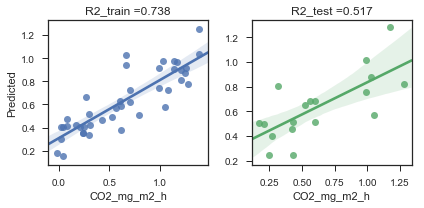

In [117]:
# Get LassoCV model
X_train = Soil_Genes_CO2_data["X_all"]
y_train = Soil_Genes_CO2_data["y"]

Soil_Genes_CO2_lassoX = lassoCV(X_train, y_train)

# plot regression fits (model predicted)
plot_model_fit_regs(Soil_Genes_CO2_data, Soil_Genes_CO2_lassoX)

# plot scaled coeffs
# plot_model_coef_colors(CO2_lassoX, CO2_mod_data, Soil_colors, fig_dim = (2, 4))

In [118]:
# Get coefficients from Genes Soils model
Soil_genes_coef = get_model_coef(Soil_Genes_CO2_lassoX, Soil_Genes_CO2_data)

# Get gene colors and merge with coeff
gene_ontol_colors['var'] = gene_ontol_colors['KO']

coef_info = pd.merge(Soil_genes_coef, gene_ontol_colors, how = 'left')    # Merge with colors, ontology (incl sm. name)
coef_info['color'] = coef_info['color'].fillna('#708090')   
coef_info['sm_name'] = coef_info['sm_name'].fillna(coef_info['var'])      # IMPORTANT -- note fill var into new label
           

coef_info['sm_name'] = coef_info['sm_name'].str.replace("," , "")
pal = coef_info['color']                  
#coef_info

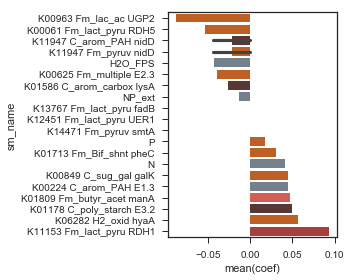

In [119]:
# pal
#pp = PdfPages("test_Lasso_Genes_no_TT.pdf")                     # Initialize the pdf file
fig = plt.figure(figsize=(5, 4))           # Define plot
sns.barplot(data=coef_info, y='sm_name', x='coef', palette=pal) #, orient='h')
fig.tight_layout()                    # Make tight layout
#pp.savefig()                            # Save the figure PDF created at top, else add file name .pdf  or  

### c) Aggregate L3 COUNT DATA

#### i) get colors, aggregate data

In [120]:
CH4nps_KOabund.head()

,Sandmound_TuleA_D1,Sandmound_TuleA_D2,Sandmound_TuleB_D1,Sandmound_TuleB_D2,Sandmound_TuleC_D1,Sandmound_TuleC_D2,Sandmound_ThreeSqA_D1_rd,Sandmound_ThreeSqA_D2,Sandmound_ThreeSqB_D1,Sandmound_ThreeSqB_D2,...,China_Bullhead_CordC_D2,China_Galinas_PWC_D2,Muzzi_CordA_D2,Muzzi_CordB_D2,Muzzi_CordC_D2,Muzzi_PWA_D1,Muzzi_PWB_D1,Muzzi_PWB_D2,Muzzi_PWC_D1,Muzzi_PWC_D2
KO,,,,,,,,,,,,,,,,,,,,,
K00847,10.9470,10.8150,10.8680,10.9110,10.841,10.9420,10.9470,10.8450,11.0110,10.8900,...,11.4330,11.4750,11.3550,11.5330,11.3460,11.3880,11.6190,11.6030,11.6010,11.4920
K00012,13.2120,13.0450,13.2390,12.9970,13.195,13.0040,13.0800,13.0270,12.9220,12.9580,...,13.0560,13.0500,12.9260,12.9500,12.8960,12.9150,12.9380,12.9330,12.9800,12.9290
K12447,3.1545,3.3375,3.0693,3.4680,3.875,3.8461,3.2620,2.6495,3.1311,3.6159,...,4.3681,4.5382,3.3491,5.2537,3.7951,4.5952,5.1321,4.6946,4.1551,3.7524
K06859,6.6914,7.1481,6.9424,7.2563,6.816,6.7535,6.1425,6.2717,6.3726,6.2621,...,8.0079,7.0260,7.6198,6.6518,7.0538,6.7850,6.6395,6.4219,6.8365,6.8696
K01835,12.7670,12.5710,12.8010,12.6230,12.668,12.5560,12.5500,12.5250,12.3110,12.3200,...,12.4830,12.4700,12.3540,12.3850,12.3990,12.5750,12.5340,12.4970,12.4360,12.3290


In [125]:
CH4nps_KOabundKO = CH4nps_KOabund
CH4nps_KOabund['KO'] = CH4nps_KOabund.index

In [121]:
L3_info = ['KO','L3']
gene_ontoL3 = gene_ontol_colors[L3_info]
gene_ontol_colors.head()
#gene_ontoL3.head()

,L1,L2,L3,L4,KO,gene,fxn,EC,sm_name,mid_name,color,var
0,Carbon,Sugars,C_sug_sucr,NaN,K00847,scrK,fructokinase,[EC:2.7.1.4],K00847 C_sug_sucr scrK,K00847 C_sug_sucr ( scrK ) fructokinase,#e94c3e,K00847
1,Carbon,Sugars,C_sug_sucr,NaN,K00012,"UGDH, ugd",UDPglucose 6-dehydrogenase,[EC:1.1.1.22],K00012 C_sug_sucr UGDH,K00012 C_sug_sucr ( UGDH ) UDPglucose 6-dehyd,#e94c3e,K00012
2,Carbon,Sugars,C_sug_sucr,NaN,K12447,USP,UDP-sugar pyrophosphorylase,[EC:2.7.7.64],K12447 C_sug_sucr USP,K12447 C_sug_sucr ( USP ) UDP-sugar pyrophos,#e94c3e,K12447
3,Carbon,Sugars,C_sug_sucr,NaN,K06859,pgi1,"glucose-6-phosphate isomerase, archaeal",[EC:5.3.1.9],K06859 C_sug_sucr pgi1,K06859 C_sug_sucr ( pgi1 ) glucose-6-phosphat,#e94c3e,K06859
4,Carbon,Sugars,C_sug_sucr,NaN,K01835,pgm,phosphoglucomutase,[EC:5.4.2.2],K01835 C_sug_sucr pgm,K01835 C_sug_sucr ( pgm ) phosphoglucomutase,#e94c3e,K01835


In [122]:
# Alternately, get aggregate counts (here, L3)

In [126]:
# Get counts / Sample for L3
L3_info = ['KO','L3']
gene_ontoL3 = gene_ontol_colors[L3_info]

CH4nps_KOabund_ont = pd.merge(gene_ontoL3, CH4nps_KOabundKO)
L3_metab_counts = CH4nps_KOabund_ont.groupby("L3").agg(np.sum).T
L3_metab_counts['Sample'] = L3_metab_counts.index

# L3_metab_counts

In [127]:
# Combine L3 counts and soil data
Soil_L3 = pd.merge(Env_chem2, L3_metab_counts, on = 'Sample')
#Soil_L3.drop(['Sample'], axis = 1, inplace = True)
#Soil_L3.head()

In [128]:
# Get colors for L3
L3_colors = ['L3', 'color']
L3_metab_colors  = gene_ontol_colors[L3_colors].drop_duplicates()

# Fix color pal for L3 & chem
L3_metab_colors['var'] = L3_metab_colors['L3']
L3_chem_colors = L3_metab_colors.append(Soil_colors)
L3_chem_colors.drop(['L3'], 1, inplace = True)
#L3_chem_colors

### ii) test train split

In [129]:
# split data, test / train
Soil_L3_CO2 = Soil_L3.drop(['CH4_ug_m2_h', 'Sample'], axis = 1)
Soil_L3_CO2_data = split_scale_data(Soil_L3_CO2, 'CO2_mg_m2_h', test_frac = 0.3, random_s = 5)

X_train : (42, 53) | X_test : (18, 53)
y_train : (42,) | y_test : (18,)


Best alpha 1: 0.01
Best alpha 2: 0.0115
Lasso RMSE on Training set : 0.36
Lasso RMSE on Test set : 1.16
R2_test =0.471
R2_train =0.735


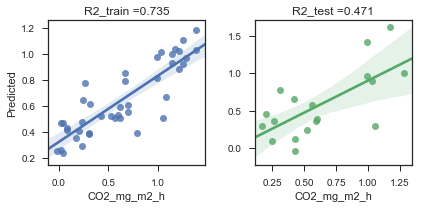

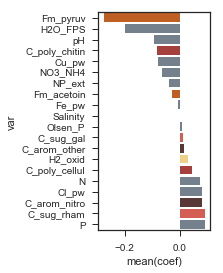

In [130]:
# Get LassoCV model
X_train = Soil_L3_CO2_data["X_all"]
y_train = Soil_L3_CO2_data["y"]

Soil_L3_CO2_lassoX = lassoCV(X_train, y_train)

# plot regression fits (model predicted)
plot_model_fit_regs(Soil_L3_CO2_data, Soil_L3_CO2_lassoX)

# plot scaled coeffs
plot_model_coef_colors(Soil_L3_CO2_lassoX, Soil_L3_CO2_data, L3_chem_colors, fig_dim = (2, 4))